In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

<Axes: >

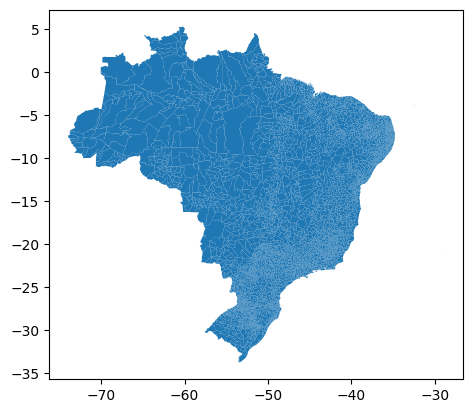

In [2]:
br = gpd.read_file(r"D:\ENS_Python\shp_br\BR_Municipios_2022.shp")
fig,ax = plt.subplots()
br.plot(ax=ax)

In [3]:
br

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry
0,1100015,Alta Floresta D'Oeste,RO,7067.127,"POLYGON ((-62.00806 -12.13379, -62.00784 -12.2..."
1,1100023,Ariquemes,RO,4426.571,"POLYGON ((-63.17933 -10.13924, -63.17746 -10.1..."
2,1100031,Cabixi,RO,1314.352,"POLYGON ((-60.52408 -13.32137, -60.37162 -13.3..."
3,1100049,Cacoal,RO,3793.000,"POLYGON ((-61.35502 -11.50452, -61.35524 -11.5..."
4,1100056,Cerejeiras,RO,2783.300,"POLYGON ((-60.82135 -13.11910, -60.81773 -13.1..."
...,...,...,...,...,...
5567,5222005,Vianópolis,GO,954.115,"POLYGON ((-48.31126 -16.84221, -48.31170 -16.8..."
5568,5222054,Vicentinópolis,GO,733.794,"POLYGON ((-49.73613 -17.74427, -49.73624 -17.7..."
5569,5222203,Vila Boa,GO,1052.593,"POLYGON ((-47.07780 -15.06364, -47.07799 -15.0..."
5570,5222302,Vila Propício,GO,2181.593,"POLYGON ((-48.58713 -15.31847, -48.58714 -15.3..."


<Axes: >

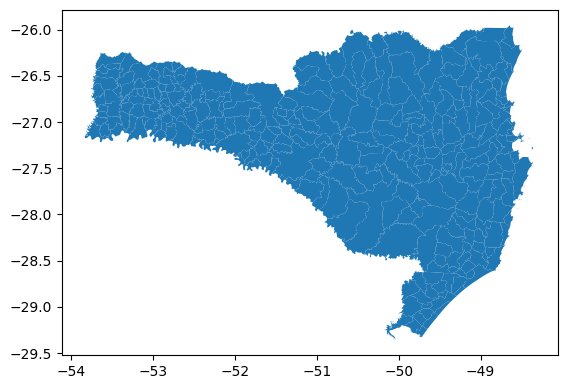

In [4]:
br[br['SIGLA_UF']=='SC'].plot()

<Axes: >

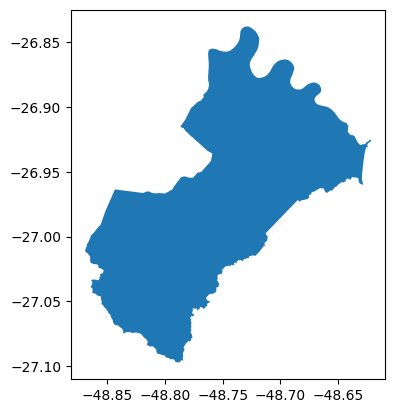

In [6]:
br[br['NM_MUN']=='Itajaí'].plot()

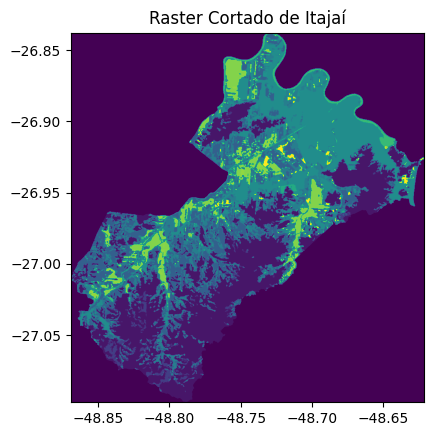

In [7]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.plot import show

# Carregue a geometria de Itajaí do shapefile
shapefile_path = r"D:\ENS_Python\shp_br\BR_Municipios_2022.shp"
municipios = gpd.read_file(shapefile_path)
geometria_itajai = municipios[municipios['NM_MUN'] == 'Itajaí'].geometry

# Carregue o raster
raster_path = r"D:\ENS_Python\brasil_coverage_2022.tif"
with rasterio.open(raster_path) as src:
    # A função mask do rasterio permite cortar um raster usando uma ou mais formas geométricas
    out_image, out_transform = mask(src, geometria_itajai, crop=True)
    
    # Copia os metadados do raster original
    out_meta = src.meta
    
    # Atualiza os metadados para refletir as novas dimensões do raster cortado
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

# Salve o raster cortado em um novo arquivo
cortado_path = r"D:\ENS_Python\itajai_coverage_2022.tif"
with rasterio.open(cortado_path, "w", **out_meta) as dest:
    dest.write(out_image)

# Se desejar, visualize o raster cortado
with rasterio.open(cortado_path) as src:
    fig, ax = plt.subplots()
    show(src, ax=ax)
    ax.set_title("Raster Cortado de Itajaí")
    plt.show()


In [9]:
from rasterstats import zonal_stats
import geopandas as gpd

# Carregar o shapefile de municípios
shapefile_path = r"D:\ENS_Python\shp_br\BR_Municipios_2022.shp"
municipios = gpd.read_file(shapefile_path)

# Isolar a geometria de Itajaí
itajai = municipios[municipios['NM_MUN'] == 'Itajaí'].copy()

# Caminho para o raster cortado de Itajaí
raster_itajai_path = r"D:\ENS_Python\itajai_coverage_2022.tif"

# Calcular as estatísticas zonais, especificando o valor de nodata se conhecido (substitua None pelo seu valor de nodata)
stats = zonal_stats(itajai, raster_itajai_path, stats="mean", nodata=None)

# Corrigindo o SettingWithCopyWarning usando .loc
itajai.loc[:, 'mean_rval'] = [stat['mean'] for stat in stats]  # 'mean_rval' é uma versão mais curta para 'mean_raster_value'

# Salvar o DataFrame de Itajaí com a nova coluna em um shapefile, assegurando-se de que os nomes das colunas são curtos o suficiente
output_itajai_shp_path = r"D:\ENS_Python\itajai_raster_values.shp"
itajai.to_file(output_itajai_shp_path)


In [12]:
import geopandas as gpd

# Caminho para o shapefile que foi salvo anteriormente
output_itajai_shp_path = r"D:\ENS_Python\itajai_raster_values.shp"

# Carregando o shapefile usando GeoPandas
itajai_shp = gpd.read_file(output_itajai_shp_path)

# Exibindo as primeiras linhas da tabela de atributos (DataFrame)
itajai_shp


,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,mean_rval,geometry
0,4208203,Itajaí,SC,289.215,16.203532,"POLYGON ((-48.66041 -26.89973, -48.65933 -26.9..."


In [13]:
itajai_shp.dtypes


CD_MUN         object
NM_MUN         object
SIGLA_UF       object
AREA_KM2      float64
mean_rval     float64
geometry     geometry
dtype: object

In [16]:
import rasterio

# Caminho para o arquivo TIFF
tiff_path = r"D:\ENS_Python\itajai_coverage_2022.tif"

# Abrindo o arquivo TIFF
with rasterio.open(tiff_path) as dataset:
    
    # Imprimindo metadados básicos
    print(f'Número de bandas: {dataset.count}')
    print(f'Dimensões: {dataset.width} x {dataset.height}')
    print(f'Sistema de coordenadas: {dataset.crs}')
    print(f'Tipos de dados: {dataset.dtypes}')
    print(f'Valores NoData: {dataset.nodatavals}')
    
    # Para cada banda, podemos imprimir informações adicionais
    for i in range(dataset.count):
        band = dataset.read(i+1)
        print(f'Informações da Banda {i+1}:')
        print(f'Mínimo: {band.min()}')
        print(f'Máximo: {band.max()}')
        print(f'Média: {band.mean()}')
        print(f'Desvio padrão: {band.std()}')

    # Se o arquivo tiver informações de metadados, podemos imprimi-las também
    print(f'Metadados: {dataset.meta}')


Número de bandas: 1
Dimensões: 919 x 962
Sistema de coordenadas: EPSG:4326
Tipos de dados: ('uint8',)
Valores NoData: (None,)
Informações da Banda 1:
Mínimo: 0
Máximo: 49
Média: 6.634651014955694
Desvio padrão: 10.986497653469357
Metadados: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 919, 'height': 962, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00026949458523585647, 0.0, -48.86907010832927,
       0.0, -0.00026949458523585647, -26.837887765298007)}
